<img src="https://upload.wikimedia.org/wikipedia/en/a/a1/Visma_logo.jpg"
     align="right"
     width="30%"
     alt="Visma logo">
     
Bankcryptcy detection in Spark
================

<img src="http://www.rm.dk/siteassets/regional-udvikling/digitalisering/dabai/dabai-logo.png"
     align="right"
     width="20%"
     alt="DABAI logo">
     
     
The following notebook, shows a version of bankcruptcy detection in Apache Spark. 

In [1]:
%run -i initilization.py

#####  Data is imported to the notebook

The dataset consists of several attributes from the CVR dataset. The primary features are:
* 'AarsVaerk_x' is a feature for the amount of 'work' done in a year, where the smallest *x* represents the latest published Årsværk
* 'medArb_x is a feature for number of employees, where the smallest *x* represents the latest published Medarbejdstal
* rank_x indicates the latest value slope which can be either positive or negative

In [2]:
excludeCols = ["medArb_"+str(i) for i in range(1,16)] # we don't need the medarbejders 

df_import = (
    sqlContext
    .read
    .parquet(PATH+"/featureDataCvr.parquet")
)
#df.show()

list_include_cols = [i for i in df_import.columns if i not in excludeCols]
rankCols = [re.sub(
    pattern="rank_",
    repl="vaerdiSlope_",
    string=i) for i in list_include_cols]
list_finalCols = [F.col(i) for i in list_include_cols[:2]]+["kortBeskrivelse"]+[F.col(i).cast("double") for i in list_include_cols[2:] if i not in ["kortBeskrivelse"]]

rankCols = [re.sub(
    pattern="rank_",
    repl="vaerdiSlope_", string=i) for i in list_include_cols ]

df_renamed = (
    df_import
    .select(*list_finalCols)
    .select([F.col(val).alias(rankCols[idx]) for idx,val in enumerate(list_include_cols)])
    .filter((F.col("kortBeskrivelse") == "APS") | (F.col("kortBeskrivelse") == "AS"))
)

In [3]:
df_renamed.limit(5).toPandas()

,cvrNummer,status,label,AarsVaerk_1,AarsVaerk_2,AarsVaerk_3,AarsVaerk_4,AarsVaerk_5,AarsVaerk_6,AarsVaerk_7,...,totalLukketEnheder,vaerdiSlope_1,vaerdiSlope_2,vaerdiSlope_3,vaerdiSlope_4,vaerdiSlope_5,vaerdiSlope_6,vaerdiSlope_7,reklamebeskyttet,kortBeskrivelse
0,10043271,[NORMAL],0.0,2.0,5.0,5.0,5.0,5.0,5.0,5.0,...,1.0,36.843721,NaN,None,None,None,None,None,0.0,APS
1,10058511,"[OPLØST EFTER ERKLÆRING, NORMAL]",0.0,1.0,2.0,2.0,2.0,1.0,NaN,NaN,...,0.0,NaN,NaN,None,None,None,None,None,0.0,APS
2,10058511,"[OPLØST EFTER ERKLÆRING, NORMAL]",0.0,1.0,2.0,2.0,2.0,1.0,NaN,NaN,...,0.0,NaN,NaN,None,None,None,None,None,0.0,APS
3,10063027,"[TVANGSOPLØST, UNDER TVANGSOPLØSNING, NORMAL]",0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0.0,105.021739,301.928571,None,None,None,None,None,0.0,APS
4,10063027,"[TVANGSOPLØST, UNDER TVANGSOPLØSNING, NORMAL]",0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0.0,105.021739,301.928571,None,None,None,None,None,0.0,APS


The first 5 data points
============

The initial data contains many rows that are blank ie. NaN, which in this case means that the company was not active a that time.

##### Import  a company dataset

In [4]:
window_spec_rank =(
    Window
    .partitionBy(F.col("cvrNummer"))
    .orderBy(F.col("periode_gyldigFra").desc())
)

groupCols = ["cvrNummer","vaerdi"]
df_companies = (
    sqlContext
    .read
    .parquet(PATH+"/companyCvrData")
    .withColumn(colName="rank",col=F.rank().over(window_spec_rank))
    .filter((F.col("rank")==1) & (F.col("sekvensnr")==0))
    .select([F.col(i) for i in groupCols])
    .withColumnRenamed(existing="vaerdi",new="navn")
    .orderBy(F.col("cvrNummer"))
    .cache()
)

In [5]:
df_companies.limit(5).toPandas()

,cvrNummer,navn
0,10000009,YELLOW
1,10000025,WATERFRONT CONNECTION
2,10000068,"STUDENTCONSULTING, FILIAL AF SVERIGES STUDENTC..."
3,10000122,DIGITAL CENTER FYN
4,10000157,WITT INVEST


##### The data is cleaned
The data is cleaned such that we replace blanks with zeros, since a company can that hasn't existed ie a blank field, has not made any 'work' or number of employees.

In [6]:
list_label_cols = ["navn",
             "cvrNummer",
             "label",
             "status",
             "kortBeskrivelse"]
list_feat_cols = [i for i in df_companies.columns+df_renamed.columns if i not in list_label_cols]

#get minimum values from each column
#minCols = [F.min(i).alias(i) for i in featCols]
#minValsRdd = (renamedDf
#              .groupby()
#              .agg(*minCols)
#              .rdd)
#broadcastedmin = sc.broadcast(minValsRdd.first().asDict())

#NOTE USED! create array that subtracts minimum value in the numeric columns.
#logColsSelected = [F.col(i).alias(i) for i in labelCols]+[(F.col(i)-F.lit(broadcastedmin.value[i])).alias(i) for i in featCols]

#NOT USED! takes log(x+1) to the numeric columns and fills the blanks with 0.0 
df_merged_company_features = (df_renamed
         .join(df_companies, 'cvrNummer', 'inner')
         #.select(*logColsSelected)
         #.select([F.col(i).alias(i) for i in labelCols]+[F.log1p(F.col(i)).alias(i) for i in featCols])
         .distinct()
         .na
         .fill(0.0, list_feat_cols)
         .cache()
        )
df_merged_company_features.limit(5).toPandas()

,cvrNummer,status,label,AarsVaerk_1,AarsVaerk_2,AarsVaerk_3,AarsVaerk_4,AarsVaerk_5,AarsVaerk_6,AarsVaerk_7,...,vaerdiSlope_1,vaerdiSlope_2,vaerdiSlope_3,vaerdiSlope_4,vaerdiSlope_5,vaerdiSlope_6,vaerdiSlope_7,reklamebeskyttet,kortBeskrivelse,navn
0,10020824,[NORMAL],0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,APS,TMC 2000
1,10022517,[NORMAL],0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.306339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,APS,BEHRENS SKOVBRUG
2,10029066,[NORMAL],0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,-9.576506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,APS,DAUM HOLDING
3,10084369,"[OPLØST EFTER SPALTNING, NORMAL]",0.0,10.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,APS,KM TELECOM SOLUTIONS
4,10100593,"[OPLØST EFTER ERKLÆRING, NORMAL]",0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,39.202875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,APS,HVASAL RUSTFRI


### Build the pipeline model

The different steps for the [Spark's Pipeline](http://spark.apache.org/docs/2.0.0/ml-pipeline.html) are initialized. 
The steps in the ML-pipeline are:
* Vectorization, data is arranged as a vector containing features.
* Standardization with mean and standard deviation.
* Machine Learning model training and optimization, we need to find the best model.


In [66]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# sort out the lables
set_label_cols = set(list_label_cols)

list_merged_feature_cols = list(set(df_merged_company_features.columns).difference(set_label_cols))
#[i for i in logDf.columns if i not in labelCols]

#toDenseUDf = F.udf(lambda x: Vectors.dense(x.toArray()), VectorUDT())

vectorizer = VectorAssembler(
    inputCols=list_merged_feature_cols,
    outputCol="features"
)

#cols_raw_vector = list(labelCols)+[toDenseUDf(vectorizer.getOutputCol()).alias(vectorizer.getOutputCol())]

#apply the stuff onto logDf
#rawVectorDataDf = (vectorizer
#                   .transform(logDf)
#                   .select(cols_raw_vector)
#                  )

vector_converter = convert(
    inputCol=vectorizer.getOutputCol(), 
    outputCol='stadard_features'
)


#standardization with mean an std is initilized
standardScale = StandardScaler(
    withMean=True,
    withStd=True,
    inputCol=vector_converter.getOutputCol(),
    outputCol="s_features"
)



#standardScaleModel = standardScale.fit(rawVectorDataDf)
#scaledFeaturesDf = (standardScaleModel
#                    .transform(rawVectorDataDf)
#                    .drop("features")
#                    .withColumnRenamed(existing="scaledFeatures",
#                                       new="features")
#                   )

log_regression = LogisticRegression(
    featuresCol=vector_converter.getOutputCol(),
    predictionCol="prediction", 
    labelCol='label',
    standardization=False,
    rawPredictionCol="rawPrediction",
    probabilityCol="probability"
)

pipeline_stages = [vectorizer,
                   vector_converter,
                   standardScale,
                   log_regression]
log_reg_pipeline = Pipeline(stages=pipeline_stages)

#scaledFeaturesDf.limit(5).toPandas()

##### Some initial stats

How many of each lables are present in the dataset?

In [67]:
(df_merged_company_features
 .groupBy('label')
 .count()
 .toPandas()
)

,label,count
0,0.0,95929
1,1.0,24309
2,2.0,576


__Note__: That we have some lables with value 2. The reason for this is that these companies have a different type of 'status' other than *normal* or *under konkurs/konkurs*, which we want to avoid in our bankcruptcy detection. 



Create a training and test datasets
----------------------------------------
The scaled dataframe is partitioned into 2 datasets in order to perform training of the model and testing of the model. The training set is later on subjected to a K-fold cross validation in order to train our prediction model.

In [68]:
# we're sampling 
df_features_test = (
    df_merged_company_features
    .filter(F.col("label") <= 1)
    .sampleBy(
        "label",
        fractions={0: 0.2, 1: 0.2})
)

(df_features_test
 .groupBy("label")
 .count()
 .toPandas()
)

df_all_cvr = df_merged_company_features.select(F.col("cvrNummer"))
df_cvr_test_df = df_features_test.select("cvrNummer")
df_cvr_train_df = df_all_cvr.subtract(df_cvr_test_df) #take the other partion as training set

df_features_train = (
    df_merged_company_features
    .filter(F.col("label") <= 1)
    .join(
        df_cvr_train_df,
        'cvrNummer',
        "inner"
    )
)

(df_features_train
 .groupBy("label")
 .count()
 .toPandas()
)
print("Number of data points: "+str(
    df_merged_company_features
    .count())
     )
print("Number of data points train: "+str(
    df_features_train
    .select("cvrNummer")
    .count())
     )
print("Number of data points test: "+str(
    df_features_test
    .select("cvrNummer")
    .count())
     )
#vectorizedTrainDf.printSchema()
#print(vectorizedTrainDf.first())

Number of data points: 120814
Number of data points train: 96145
Number of data points test: 24093


### Lets fit the model to our training data

In [69]:
model = log_reg_pipeline.fit(df_features_train)

###  Lets apply the model to our test data

In [70]:
df_fitted = model.transform(df_features_test)

__How did it go?__

In [71]:
(df_fitted
 .select(
     F.col('label').cast('integer').alias('Truth'),
     F.col('prediction').cast('integer').alias('Predicted'))
 .groupBy(
     'Truth',
     'Predicted')
 .count()
 .limit(5)
 .toPandas()
)

,Truth,Predicted,count
0,1,0,4494
1,1,1,306
2,0,0,19123
3,0,1,170


Looks like we have a lot of False negatives; {{Out[15]['count'][0]}} to be exact. On the other hand, we *only* have {{Out[15]['count'][3]}} False Positives. Looks like our model is basically setting almost all companies to *'Not going bankcrupt'* - Lets take a look at K-fold cross-validation.



### K-fold cross-validation

The following cell runs a K-fold cross-validation, which is implemented in Apache Spark as the class: [CrossValidator](http://spark.apache.org/docs/2.0.0/ml-tuning.html). In order to make the Cross-validation work, we import: 
* Apache Spark Pipeline
* [Parametergrid](http://spark.apache.org/docs/2.0.0/api/python/pyspark.ml.html#module-pyspark.ml.tuning) that contains the parameters that are used for an exhaustive grid search.
* An evaluation metric, since the problem at hand deals with a binary classification problem, we have included the class [BinaryClassificationEvaluator](http://spark.apache.org/docs/2.0.0/api/python/pyspark.ml.html#pyspark.ml.evaluation.BinaryClassificationEvaluator)

In [72]:
#Train the logistic regressionmodel

grid = (ParamGridBuilder()
        .addGrid(param=log_regression.elasticNetParam, values=[0.1, 1.0])
        .addGrid(param=log_regression.maxIter, values=[10, 20, 40])
        .addGrid(param=log_regression.threshold, values=[0.2, 0.5, 0.8])
        .build()
       )
evaluate = BinaryClassificationEvaluator(
    rawPredictionCol="rawPrediction")
crossVal = CrossValidator(
    estimator=log_reg_pipeline,
    estimatorParamMaps=grid,
    evaluator=evaluate,
    numFolds=10
)

crossValModel = crossVal.fit(
    dataset=df_features_train)
evaluate.evaluate(
    crossValModel.transform(df_features_train))
#coef = lrModel.coefficients

0.8145691778974767

Lets apply the model to the test dataset.

In [73]:
df_best_fitted_model = crossValModel.transform(df_features_test)

In [74]:
(df_best_fitted_model
 .select(
     F.col('label').cast('integer').alias('Truth'),
     F.col('prediction').cast('integer').alias('Predicted'))
 .groupBy(
     'Truth',
     'Predicted')
 .count()
 .limit(5)
 .toPandas()
)

,Truth,Predicted,count
0,1,0,4443
1,1,1,357
2,0,0,19087
3,0,1,206


The area under the curve is 0.8145544129170766


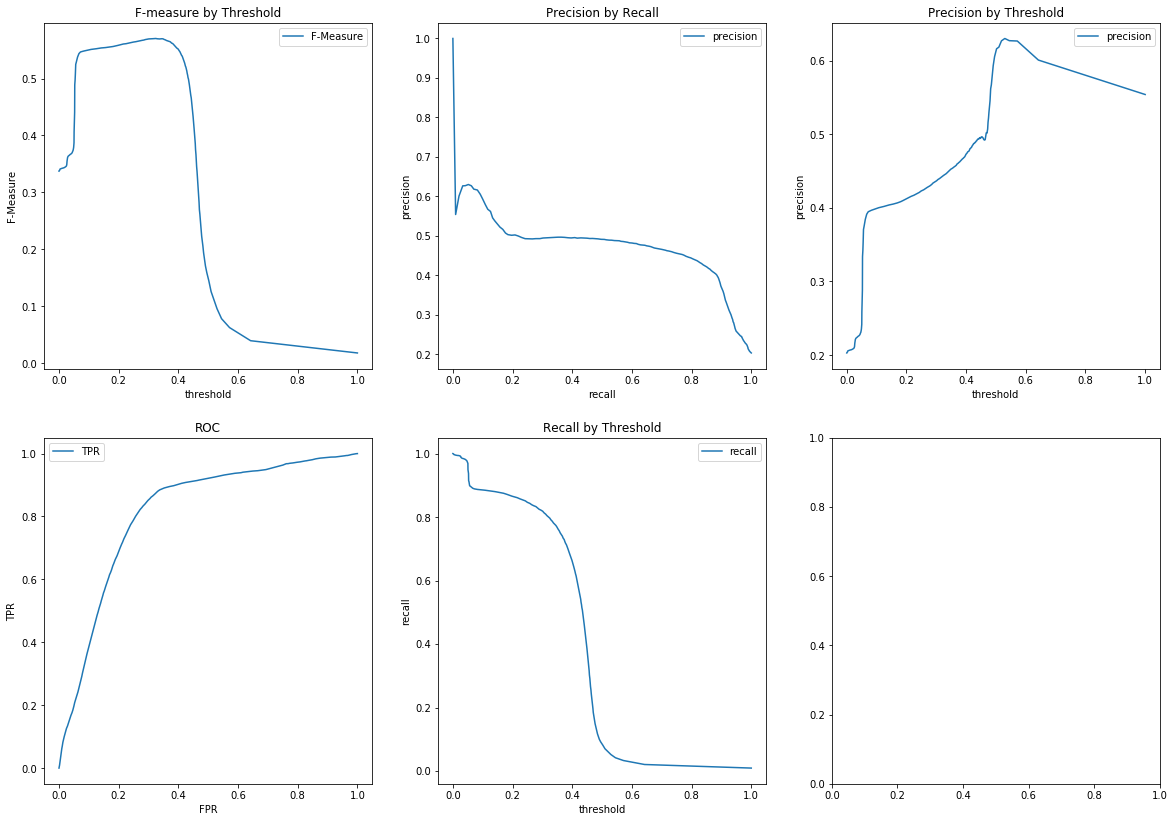

In [75]:
if crossValModel.bestModel.stages[-1].hasSummary:
    fig, axes = plt.subplots(
        nrows=2,
        ncols=3,
        figsize=(20, 14))
    summary = crossValModel.bestModel.stages[-1].summary
    
    
    print('The area under the curve is {}'.format(summary.areaUnderROC))
    attributes = []
    titles = ['F-measure by Threshold','Precision by Recall','Precision by Threshold', 'ROC', 'Recall by Threshold']
    attributes.append(summary.fMeasureByThreshold.toPandas())
    attributes.append(summary.pr.toPandas())
    attributes.append(summary.precisionByThreshold.toPandas())
    attributes.append(summary.roc.toPandas())
    attributes.append(summary.recallByThreshold.toPandas())
    #iterations = summary.totalIterations
    
    jdx = 0
    for idx, data_frame in enumerate(attributes):
        if idx % 3 == 0 and idx != 0:
            jdx+=1
        ax = axes[jdx,idx % 3]
        ax.plot(data_frame.columns[0],
                data_frame.columns[1],
                data=data_frame,                
               )
        ax.legend()
        ax.set_xlabel(data_frame.columns[0])
        ax.set_ylabel(data_frame.columns[1])
        ax.set_title(titles[idx])
    plt.show()
    
    


Ok again it appears that our model isn't that good, looking at the curvers.
Another approach is to use: *'a clustering-then-labling approach'*, ie. semi-supervised, could be used in the training phase, in order to identify a new set of *lables*. These lables might be different compared to the preassigned lables, that are provided ie. some companies that have status: *'normal'* might not be that healthy. Afterwards, can the generated classification model be used to classify the data, hopefully, better. 

An initial Semi-supervised approach
=============

The following cell initializes a KMeans clustering algorithm along with a new instance of Logistic regression in order to use the *km_label* as prediction label.

In [57]:
from pyspark.ml.clustering import KMeans

k_means = KMeans(
    featuresCol=standardScale.getOutputCol(),
    maxIter=40,
    predictionCol='km_label',
    k=2,
    initMode='random',
    initSteps=10
)

semi_super_log_reg = LogisticRegression(
    featuresCol=standardScale.getOutputCol(),
    standardization=False,
    labelCol=k_means.getPredictionCol()
)

cast_km_label_col = CastInPipeline(
    inputCol=k_means.getPredictionCol(),
    castTo='double')


list_semi_super_stages = [vectorizer,
                          vector_converter,
                          standardScale,
                          k_means,
                          cast_km_label_col,
                          semi_super_log_reg]

semi_super_pipeline = Pipeline(stages=list_semi_super_stages)

A new instance of K-fold cross-validation is created below

In [58]:
#Train the logistic regressionmodel
ss_grid = (ParamGridBuilder()
        .addGrid(
            param=semi_super_log_reg.threshold,
            values=[.2, .5, .8])
        .addGrid(
            param=semi_super_log_reg.maxIter,
            values=[10, 20, 40])
        .addGrid(
            param=log_regression.elasticNetParam,
            values=[0.1, 1.0])
        .build()
       )
ss_evaluate = BinaryClassificationEvaluator(
    rawPredictionCol="rawPrediction")

ss_crossVal = CrossValidator(
    estimator=semi_super_pipeline,
    estimatorParamMaps=ss_grid,
    evaluator=ss_evaluate,
    numFolds=10
)

ss_crossValModel = ss_crossVal.fit(
    dataset=df_features_train)
ss_evaluate.evaluate(
    ss_crossValModel.transform(df_features_train))
#coef = lrModel.coefficients

0.739777606100737

In [59]:
df_best_fitted_semi_super_model = ss_crossValModel.transform(df_features_test)

In [60]:
df_best_fitted_semi_super_model.limit(5).toPandas()

,cvrNummer,status,label,AarsVaerk_1,AarsVaerk_2,AarsVaerk_3,AarsVaerk_4,AarsVaerk_5,AarsVaerk_6,AarsVaerk_7,...,reklamebeskyttet,kortBeskrivelse,navn,features,stadard_features,s_features,km_label,rawPrediction,probability,prediction
0,13198934,[NORMAL],0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,APS,C.T. VÆRKTØJ,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, ...","[0.410222215031, -0.152194054413, -0.019630727...",0.0,"[1097.34043071, -1097.34043071]","[1.0, 0.0]",0.0
1,13249040,"[OPLØST EFTER FRIVILLIG LIKVIDATION, UNDER FRI...",0.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,APS,VICH 1569,"[0.0, 1.0, 2.0, 2.0, 2.0, 51.0421097405, 5.0, ...","[0.0, 1.0, 2.0, 2.0, 2.0, 51.0421097405, 5.0, ...","[-0.630029689664, -0.152194054413, 0.097629469...",1.0,"[-2654.04943471, 2654.04943471]","[0.0, 1.0]",1.0
2,13347735,"[OPLØST EFTER ERKLÆRING, NORMAL]",0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,1.0,APS,HUSETS VVS,"(0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[-0.630029689664, -0.152194054413, -0.01963072...",1.0,"[-977.293755807, 977.293755807]","[0.0, 1.0]",1.0
3,13868735,[NORMAL],0.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,...,0.0,APS,POUL KUDSK TRÆAGENTUR,"[1.0, 2.0, 2.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, ...","[1.0, 2.0, 2.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, ...","[0.410222215031, -0.0607313864665, 0.097629469...",1.0,"[-605.58332859, 605.58332859]","[9.96556808799e-264, 1.0]",1.0
4,14346198,[NORMAL],0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,APS,SANGILD DAMBRUG,"(1.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, ...","[0.410222215031, -0.0607313864665, 0.097629469...",0.0,"[1054.29897755, -1054.29897755]","[1.0, 0.0]",0.0


Compute the confusion matrix again

In [61]:
(df_best_fitted_semi_super_model
 .select(
     F.col('label').cast('integer').alias('Truth'),
     F.col('prediction').cast('integer').alias('Predicted'))
 .groupBy(
     'Truth',
     'Predicted')
 .count()
 .limit(5)
 .toPandas()
)

,Truth,Predicted,count
0,1,0,585
1,1,1,4335
2,0,0,12273
3,0,1,6851


### The summary is shown below

The area under the curve is 0.9999999802488896


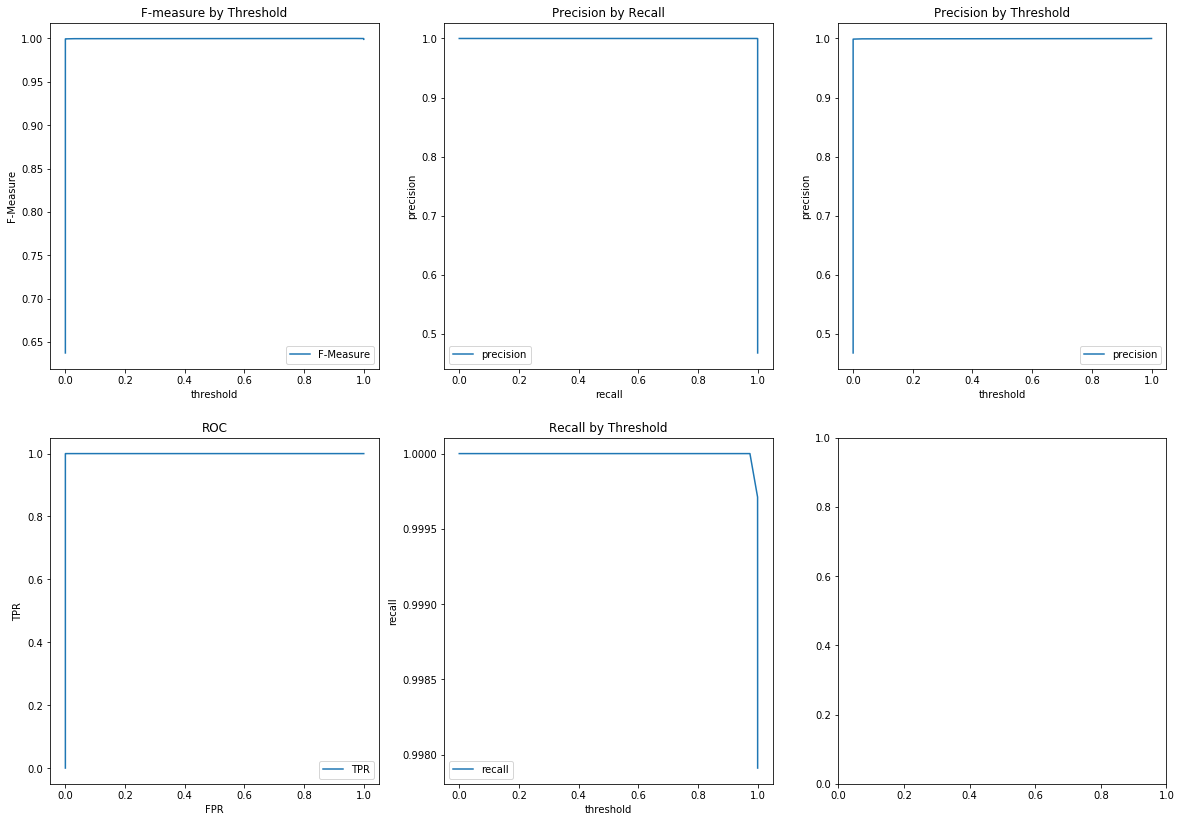

In [62]:
if ss_crossValModel.bestModel.stages[-1].hasSummary:
    fig, axes = plt.subplots(
        nrows=2,
        ncols=3,
        figsize=(20, 14))
    ss_summary = ss_crossValModel.bestModel.stages[-1].summary
    
    
    print('The area under the curve is {}'.format(ss_summary.areaUnderROC))
    attributes = []
    titles = ['F-measure by Threshold','Precision by Recall','Precision by Threshold', 'ROC', 'Recall by Threshold']
    attributes.append(ss_summary.fMeasureByThreshold.toPandas())
    attributes.append(ss_summary.pr.toPandas())
    attributes.append(ss_summary.precisionByThreshold.toPandas())
    attributes.append(ss_summary.roc.toPandas())
    attributes.append(ss_summary.recallByThreshold.toPandas())
    #iterations = summary.totalIterations
    
    jdx = 0
    for idx, data_frame in enumerate(attributes):
        if idx % 3 == 0 and idx != 0:
            jdx+=1
        ax = axes[jdx,idx % 3]
        ax.plot(data_frame.columns[0],
                data_frame.columns[1],
                data=data_frame,                
               )
        ax.legend()
        ax.set_xlabel(data_frame.columns[0])
        ax.set_ylabel(data_frame.columns[1])
        ax.set_title(titles[idx])
    plt.show()